# Data Scientist Professional Practical Exam

### Company Background

Nearly New Nautical is a website that allows users to advertise their used boats for sale. When users list their boat, they have to provide a range of information about their boat. Boats that get lots of views bring more traffic to the website, and more potential customers. 

To boost traffic to the website, the product manager wants to prevent listing boats that do not receive many views.




### Customer Question

The product manager wants to know the following:
- Can you predict the number of views a listing will receive based on the boat's features?



### Success Criteria

The product manager would consider using your model if, on average, the predictions were only 50% off of the true number of views a listing would receive.


### Dataset

The data you will use for this analysis can be accessed here: `"data/boat_data.csv"`

# Use this cell to begin, and add as many cells as you need to complete your analysis!
## Data Validation & Data Cleaning
Dataset contains 9888 entries, 10 columns. Column names have been updated to lower case and snake case.
- list_price (numeric): strip whitespace. split column into currency (non-numeric) and price_euro (numeric). update all prices to euro.

- boat_type (non-numeric): 126 initial -> 26 unique values. convert to lowercase and strip whitespace. split column into boat_type_1 (non-numeric), boat_type_2 (non-numeric), boat_type_3 (non-numeric) for each unique category found. fill None type with numpy NA.
- manufacturer (non-numeric): 910 unique values. dropped due to high categorical cardinality.
- type (non-numeric): 24 initial -> 4 unique values. convert to lowercase and remove whitespace. split column into condition (non-numeric) and fuel (non-numeric). fill None type with numpy NA. move all remaining fuel types in condition column to fuel column
- year_built (numeric): assume any 0 are purchased in current year (2022). feature engineer year_built (numeric) to age (numeric).
- length (numeric): should contain values greater than or equal to 0 and that are not very high.
- width (numeric): should contain values greater than or equal to 0 and that are not very high.
- material (non-numeric): 11 unique values. convert to lowercase.
- location (non-numeric): 2995 unique values. dropped due to high categorical cardinality.
- past_7_day_views (numeric): should contain values greater than or equal to 0 and that are not very high.

After above steps, dataframe's columns 10 columns -> 22 columns. Of which, will select 8 columns to conduct exploratory data analysis (EDA).

In [2]:
# import neccessary packages
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%config ZMQInteractiveShell.ast_node_interactivity='all'
%config IPCompleter.greedy = True
%matplotlib inline
sns.set_theme()
pd.options.display.max_columns = None
pd.options.display.max_rows = 200

In [3]:
# import csv dataset as a dataframe
df = pd.read_csv("./data/boat_data.csv")

# column names to be aligned with python naming convention
df.columns = [
    "list_price",
    "boat_type",
    "manufacturer",
    "type",
    "year_built",
    "length",
    "width",
    "material",
    "location",
    "past_7_day_views",
]

# correct encoding for all object columns in dataframe
df.update(df.select_dtypes(include='object').apply(lambda x: x.str.encode('latin_1').str.decode('utf_8')))

# display dataframe column information
display(df.info())

# count missing values
display(df.isna().sum())

# count duplicated rows
display(df.duplicated().sum())

# display descriptive statistics
display(df.describe(include='all'))

# display dataframe
display(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9888 entries, 0 to 9887
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   list_price        9888 non-null   object 
 1   boat_type         9888 non-null   object 
 2   manufacturer      8550 non-null   object 
 3   type              9882 non-null   object 
 4   year_built        9888 non-null   int64  
 5   length            9879 non-null   float64
 6   width             9832 non-null   float64
 7   material          8139 non-null   object 
 8   location          9852 non-null   object 
 9   past_7_day_views  9888 non-null   int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 772.6+ KB


None

list_price             0
boat_type              0
manufacturer        1338
type                   6
year_built             0
length                 9
width                 56
material            1749
location              36
past_7_day_views       0
dtype: int64

0

,list_price,boat_type,manufacturer,type,year_built,length,width,material,location,past_7_day_views
count,9888,9888,8550,9882,9888.000000,9879.000000,9832.000000,8139,9852,9888.000000
unique,3182,126,910,24,NaN,NaN,NaN,11,2995,NaN
top,EUR 65000,Motor Yacht,Bénéteau power boats,"Used boat,Diesel",NaN,NaN,NaN,GRP,Netherlands » In verkoophaven,NaN
freq,77,2720,631,4140,NaN,NaN,NaN,5484,309,NaN
mean,NaN,NaN,NaN,NaN,1893.192860,11.570017,3.520124,NaN,NaN,149.160801
std,NaN,NaN,NaN,NaN,460.201582,6.002820,1.220534,NaN,NaN,151.819752
min,NaN,NaN,NaN,NaN,0.000000,1.040000,0.010000,NaN,NaN,13.000000
25%,NaN,NaN,NaN,NaN,1996.000000,7.470000,2.540000,NaN,NaN,70.000000
50%,NaN,NaN,NaN,NaN,2007.000000,10.280000,3.330000,NaN,NaN,108.000000
75%,NaN,NaN,NaN,NaN,2017.000000,13.930000,4.250000,NaN,NaN,172.000000


,list_price,boat_type,manufacturer,type,year_built,length,width,material,location,past_7_day_views
0,CHF 3337,Motor Yacht,Rigiflex power boats,new boat from stock,2017,4.00,1.90,NaN,Switzerland » Lake Geneva » Vésenaz,226
1,EUR 3490,Center console boat,Terhi power boats,new boat from stock,2020,4.00,1.50,Thermoplastic,Germany » Bönningstedt,75
2,CHF 3770,Sport Boat,Marine power boats,new boat from stock,0,3.69,1.42,Aluminium,Switzerland » Lake of Zurich » Stäfa ZH,124
3,DKK 25900,Sport Boat,Pioner power boats,new boat from stock,2020,3.00,1.00,NaN,Denmark » Svendborg,64
4,EUR 3399,Fishing Boat,Linder power boats,new boat from stock,2019,3.55,1.46,Aluminium,Germany » Bayern » München,58
...,...,...,...,...,...,...,...,...,...,...
9883,CHF 4900,Sport Boat,Sea Ray power boats,"Used boat,Unleaded",1987,6.30,2.44,NaN,Switzerland » Lago Maggiore » Riazzino,1116
9884,EUR 4516,Sport Boat,NaN,new boat from stock,0,4.17,1.68,GRP,Germany » Hamburg » HAMBURG,94
9885,EUR 4499,Sport Boat,BlueCraft power boats,"new boat from stock,Unleaded",2020,4.40,1.80,GRP,Germany » Nordrhein-Westfalen » Wesel,354
9886,EUR 4300,Pontoon Boat,Whaly power boats,new boat from stock,2018,4.37,1.89,NaN,Italy » Dormelletto,266


list_price

In [4]:
# strip whitespace
df['list_price'] = df.list_price.str.strip()

# seperate column into currency and price
df[['currency', 'list_price']] = df.list_price.str.split(' ', expand=True)

# display all unique currency values that need to be converted
display(df.currency.unique())

# pull information on currency exchanges to euro from https://www.xe.com/currencyconverter/ and create conversion dictionary
currency_conversion = {'CHF': 1.01603, 'EUR': 1.0, 'DKK': 0.134454, '£': 1.14981}

# map each currency symbol to its numeric equivalent
df['currency_conversion'] = df['currency'].map(currency_conversion)

# convert all different currencies into euro
df['list_price_euro'] = (df['list_price'].astype('float64') * df['currency_conversion']).astype('int64')

# display first 5 rows of dataframe
display(df.head())

# validate price_euro to be equal to the number of rows (meaning all rows have a price)
assert df['list_price_euro'].size == df.shape[0]

array(['CHF', 'EUR', 'DKK', '£'], dtype=object)

,list_price,boat_type,manufacturer,type,year_built,length,width,material,location,past_7_day_views,currency,currency_conversion,list_price_euro
0,3337,Motor Yacht,Rigiflex power boats,new boat from stock,2017,4.00,1.90,NaN,Switzerland » Lake Geneva » Vésenaz,226,CHF,1.016030,3390
1,3490,Center console boat,Terhi power boats,new boat from stock,2020,4.00,1.50,Thermoplastic,Germany » Bönningstedt,75,EUR,1.000000,3490
2,3770,Sport Boat,Marine power boats,new boat from stock,0,3.69,1.42,Aluminium,Switzerland » Lake of Zurich » Stäfa ZH,124,CHF,1.016030,3830
3,25900,Sport Boat,Pioner power boats,new boat from stock,2020,3.00,1.00,NaN,Denmark » Svendborg,64,DKK,0.134454,3482
4,3399,Fishing Boat,Linder power boats,new boat from stock,2019,3.55,1.46,Aluminium,Germany » Bayern » München,58,EUR,1.000000,3399


boat_type

In [5]:
# convert to lowercase and strip whitespace
df['boat_type'] = df['boat_type'].str.lower().str.strip()

# split each row of data into columns based on the different boat types
df[['boat_type_1', 'boat_type_2', 'boat_type_3']] = df['boat_type'].str.split(',', expand=True)

# replace None type with np.nan type
df[['boat_type_1', 'boat_type_2', 'boat_type_3']] = df[['boat_type_1', 'boat_type_2', 'boat_type_3']].fillna(np.nan)

# validate 26 types of boats
df['boat_type_1'].unique()

# display first 5 rows of dataframe
display(df.head())

array(['motor yacht', 'center console boat', 'sport boat', 'fishing boat',
       'catamaran', 'pontoon boat', 'runabout', 'deck boat', 'pilothouse',
       'cabin boat', 'working boat', 'classic', 'bowrider', 'trawler',
       'launch', 'flybridge', 'water ski', 'hardtop', 'offshore boat',
       'wakeboard/wakesurf', 'passenger boat', 'house boat', 'ketch',
       'mega yacht', 'motorsailer', 'rib'], dtype=object)

,list_price,boat_type,manufacturer,type,year_built,length,width,material,location,past_7_day_views,currency,currency_conversion,list_price_euro,boat_type_1,boat_type_2,boat_type_3
0,3337,motor yacht,Rigiflex power boats,new boat from stock,2017,4.00,1.90,NaN,Switzerland » Lake Geneva » Vésenaz,226,CHF,1.016030,3390,motor yacht,NaN,NaN
1,3490,center console boat,Terhi power boats,new boat from stock,2020,4.00,1.50,Thermoplastic,Germany » Bönningstedt,75,EUR,1.000000,3490,center console boat,NaN,NaN
2,3770,sport boat,Marine power boats,new boat from stock,0,3.69,1.42,Aluminium,Switzerland » Lake of Zurich » Stäfa ZH,124,CHF,1.016030,3830,sport boat,NaN,NaN
3,25900,sport boat,Pioner power boats,new boat from stock,2020,3.00,1.00,NaN,Denmark » Svendborg,64,DKK,0.134454,3482,sport boat,NaN,NaN
4,3399,fishing boat,Linder power boats,new boat from stock,2019,3.55,1.46,Aluminium,Germany » Bayern » München,58,EUR,1.000000,3399,fishing boat,NaN,NaN


manufacturer

In [6]:
# convert to lowercase and remove whitespace
df['manufacturer'] = df['manufacturer'].str.lower().str.strip()

# drop manufacturer column due to high categorical cardinality
df = df.drop(columns='manufacturer')

# diplay first 5 rows of dataframe
display(df.head())

,list_price,boat_type,type,year_built,length,width,material,location,past_7_day_views,currency,currency_conversion,list_price_euro,boat_type_1,boat_type_2,boat_type_3
0,3337,motor yacht,new boat from stock,2017,4.00,1.90,NaN,Switzerland » Lake Geneva » Vésenaz,226,CHF,1.016030,3390,motor yacht,NaN,NaN
1,3490,center console boat,new boat from stock,2020,4.00,1.50,Thermoplastic,Germany » Bönningstedt,75,EUR,1.000000,3490,center console boat,NaN,NaN
2,3770,sport boat,new boat from stock,0,3.69,1.42,Aluminium,Switzerland » Lake of Zurich » Stäfa ZH,124,CHF,1.016030,3830,sport boat,NaN,NaN
3,25900,sport boat,new boat from stock,2020,3.00,1.00,NaN,Denmark » Svendborg,64,DKK,0.134454,3482,sport boat,NaN,NaN
4,3399,fishing boat,new boat from stock,2019,3.55,1.46,Aluminium,Germany » Bayern » München,58,EUR,1.000000,3399,fishing boat,NaN,NaN


type

In [7]:
# convert to lowercase
df['type'] = df['type'].str.lower()

# split each row of data into columns condition and fuel
df[['condition', 'fuel']] = df['type'].str.split(',', expand=True)

# replace None type with np.nan type
df[['condition', 'fuel']] = df[['condition', 'fuel']].fillna(np.nan)

# move all remaining fuel types from condition column to fuel column
df['fuel'].update(df.loc[df["condition"].isin(["diesel", "unleaded", "electric"]), "condition"])

# replace all remaining fuel types with numpy NA
df["condition"].replace({"diesel":np.nan, "unleaded":np.nan, "electric":np.nan}, inplace=True)

# validate 4 unique condition values (not including NA)
df['condition'].unique()

# validate 6 unique fuel values (not including NA)
df['fuel'].unique()

# display first 5 rows of dataframe
display(df.head())

array(['new boat from stock', 'used boat', 'new boat on order', nan,
       'display model'], dtype=object)

array([nan, 'unleaded', 'electric', 'diesel', 'gas', 'hybrid', 'propane'],
      dtype=object)

,list_price,boat_type,type,year_built,length,width,material,location,past_7_day_views,currency,currency_conversion,list_price_euro,boat_type_1,boat_type_2,boat_type_3,condition,fuel
0,3337,motor yacht,new boat from stock,2017,4.00,1.90,NaN,Switzerland » Lake Geneva » Vésenaz,226,CHF,1.016030,3390,motor yacht,NaN,NaN,new boat from stock,NaN
1,3490,center console boat,new boat from stock,2020,4.00,1.50,Thermoplastic,Germany » Bönningstedt,75,EUR,1.000000,3490,center console boat,NaN,NaN,new boat from stock,NaN
2,3770,sport boat,new boat from stock,0,3.69,1.42,Aluminium,Switzerland » Lake of Zurich » Stäfa ZH,124,CHF,1.016030,3830,sport boat,NaN,NaN,new boat from stock,NaN
3,25900,sport boat,new boat from stock,2020,3.00,1.00,NaN,Denmark » Svendborg,64,DKK,0.134454,3482,sport boat,NaN,NaN,new boat from stock,NaN
4,3399,fishing boat,new boat from stock,2019,3.55,1.46,Aluminium,Germany » Bayern » München,58,EUR,1.000000,3399,fishing boat,NaN,NaN,new boat from stock,NaN


year_built

In [8]:
# display descriptive statistics
df['year_built'].describe()

# replace all 0 with 2022 (latest year)
df['year_built'] = df['year_built'].replace({0: 2022})

# display updated descriptive statistics
df['year_built'].describe()

# create new column accounting for age
df['age_in_years'] = 2022 - df['year_built']

# validate for values greater than or equal to 0
df['age_in_years'].unique()

# display first 5 rows of dataframe
display(df.head())

count    9888.000000
mean     1893.192860
std       460.201582
min         0.000000
25%      1996.000000
50%      2007.000000
75%      2017.000000
max      2021.000000
Name: year_built, dtype: float64

count    9888.000000
mean     2005.867011
std        16.370045
min      1885.000000
25%      2000.000000
50%      2008.000000
75%      2019.000000
max      2022.000000
Name: year_built, dtype: float64

array([  5,   2,   0,   3,  23,   4,  35,  18,  25,  37,  41,  11,  43,
        24,  28,  26,  50,  42,  48,  39,  31,  30,  61,   7,  22,  29,
        54,  15,  32,  12,  47,  36,  81,  51,  17,  27,  46,  21,  16,
         6,  38,  58,  44,  82,  34,  19,  45,  49,  52, 109,  57,  72,
         8,  20,  59,  14,  74,  62,  92,  13,  33,  53,  40,  85,   9,
        10,  68,  63, 113,  96, 112,  60,  84,  86,  55, 119,  89, 116,
       114,   1,  95,  93,  66,  64, 100,  70,  65,  94, 117,  71, 111,
        56, 107,  88,  83,  69,  98,  91, 102, 124,  67, 115, 137, 127,
       108, 121,  80, 103,  97, 133,  76, 118,  99, 105,  87,  73,  75,
       110,  77, 125, 120, 122])

,list_price,boat_type,type,year_built,length,width,material,location,past_7_day_views,currency,currency_conversion,list_price_euro,boat_type_1,boat_type_2,boat_type_3,condition,fuel,age_in_years
0,3337,motor yacht,new boat from stock,2017,4.00,1.90,NaN,Switzerland » Lake Geneva » Vésenaz,226,CHF,1.016030,3390,motor yacht,NaN,NaN,new boat from stock,NaN,5
1,3490,center console boat,new boat from stock,2020,4.00,1.50,Thermoplastic,Germany » Bönningstedt,75,EUR,1.000000,3490,center console boat,NaN,NaN,new boat from stock,NaN,2
2,3770,sport boat,new boat from stock,2022,3.69,1.42,Aluminium,Switzerland » Lake of Zurich » Stäfa ZH,124,CHF,1.016030,3830,sport boat,NaN,NaN,new boat from stock,NaN,0
3,25900,sport boat,new boat from stock,2020,3.00,1.00,NaN,Denmark » Svendborg,64,DKK,0.134454,3482,sport boat,NaN,NaN,new boat from stock,NaN,2
4,3399,fishing boat,new boat from stock,2019,3.55,1.46,Aluminium,Germany » Bayern » München,58,EUR,1.000000,3399,fishing boat,NaN,NaN,new boat from stock,NaN,3


length, width

In [9]:
# validate for values greater than or equal to 0 and are not very high in both features
df[['length', 'width']].describe()

,length,width
count,9879.000000,9832.000000
mean,11.570017,3.520124
std,6.002820,1.220534
min,1.040000,0.010000
25%,7.470000,2.540000
50%,10.280000,3.330000
75%,13.930000,4.250000
max,100.000000,25.160000


material

In [10]:
# convert to lowercase
df['material'] = df['material'].str.lower()

# validate 11 types of material (not including NA)
df['material'].unique()

# diplay first five rows of data
display(df.head())

array([nan, 'thermoplastic', 'aluminium', 'grp', 'pvc', 'plastic', 'wood',
       'steel', 'hypalon', 'carbon fiber', 'reinforced concrete',
       'rubber'], dtype=object)

,list_price,boat_type,type,year_built,length,width,material,location,past_7_day_views,currency,currency_conversion,list_price_euro,boat_type_1,boat_type_2,boat_type_3,condition,fuel,age_in_years
0,3337,motor yacht,new boat from stock,2017,4.00,1.90,NaN,Switzerland » Lake Geneva » Vésenaz,226,CHF,1.016030,3390,motor yacht,NaN,NaN,new boat from stock,NaN,5
1,3490,center console boat,new boat from stock,2020,4.00,1.50,thermoplastic,Germany » Bönningstedt,75,EUR,1.000000,3490,center console boat,NaN,NaN,new boat from stock,NaN,2
2,3770,sport boat,new boat from stock,2022,3.69,1.42,aluminium,Switzerland » Lake of Zurich » Stäfa ZH,124,CHF,1.016030,3830,sport boat,NaN,NaN,new boat from stock,NaN,0
3,25900,sport boat,new boat from stock,2020,3.00,1.00,NaN,Denmark » Svendborg,64,DKK,0.134454,3482,sport boat,NaN,NaN,new boat from stock,NaN,2
4,3399,fishing boat,new boat from stock,2019,3.55,1.46,aluminium,Germany » Bayern » München,58,EUR,1.000000,3399,fishing boat,NaN,NaN,new boat from stock,NaN,3


location

In [11]:
# conver to lowercase
df['location'] = df['location'].str.lower()

# drop location column due to high categorical cardinality
df = df.drop(columns='location')

# diplay first 5 rows of dataframe
display(df.head())

,list_price,boat_type,type,year_built,length,width,material,past_7_day_views,currency,currency_conversion,list_price_euro,boat_type_1,boat_type_2,boat_type_3,condition,fuel,age_in_years
0,3337,motor yacht,new boat from stock,2017,4.00,1.90,NaN,226,CHF,1.016030,3390,motor yacht,NaN,NaN,new boat from stock,NaN,5
1,3490,center console boat,new boat from stock,2020,4.00,1.50,thermoplastic,75,EUR,1.000000,3490,center console boat,NaN,NaN,new boat from stock,NaN,2
2,3770,sport boat,new boat from stock,2022,3.69,1.42,aluminium,124,CHF,1.016030,3830,sport boat,NaN,NaN,new boat from stock,NaN,0
3,25900,sport boat,new boat from stock,2020,3.00,1.00,NaN,64,DKK,0.134454,3482,sport boat,NaN,NaN,new boat from stock,NaN,2
4,3399,fishing boat,new boat from stock,2019,3.55,1.46,aluminium,58,EUR,1.000000,3399,fishing boat,NaN,NaN,new boat from stock,NaN,3


past_7_day_views

In [12]:
# validate for values greater than or equal to 0 and are not very high
df['past_7_day_views'].describe()

count    9888.000000
mean      149.160801
std       151.819752
min        13.000000
25%        70.000000
50%       108.000000
75%       172.000000
max      3263.000000
Name: past_7_day_views, dtype: float64

In [13]:
# create new dataframe with updates and cleaned columns for exploratory data analysis
df_eda = df[['list_price_euro', 'boat_type_1', 'condition', 'age_in_years','length', 'width', 'material', 'past_7_day_views']]

# display dataframe
display(df_eda)

# display dataframe column information
display(df_eda.info())

# count missing values
display(df_eda.isna().sum())

# display descriptive statistics
display(df_eda.describe(include='all'))

,list_price_euro,boat_type_1,condition,age_in_years,length,width,material,past_7_day_views
0,3390,motor yacht,new boat from stock,5,4.00,1.90,NaN,226
1,3490,center console boat,new boat from stock,2,4.00,1.50,thermoplastic,75
2,3830,sport boat,new boat from stock,0,3.69,1.42,aluminium,124
3,3482,sport boat,new boat from stock,2,3.00,1.00,NaN,64
4,3399,fishing boat,new boat from stock,3,3.55,1.46,aluminium,58
...,...,...,...,...,...,...,...,...
9883,4978,sport boat,used boat,35,6.30,2.44,NaN,1116
9884,4516,sport boat,new boat from stock,0,4.17,1.68,grp,94
9885,4499,sport boat,new boat from stock,2,4.40,1.80,grp,354
9886,4300,pontoon boat,new boat from stock,4,4.37,1.89,NaN,266


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9888 entries, 0 to 9887
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   list_price_euro   9888 non-null   int64  
 1   boat_type_1       9888 non-null   object 
 2   condition         9802 non-null   object 
 3   age_in_years      9888 non-null   int64  
 4   length            9879 non-null   float64
 5   width             9832 non-null   float64
 6   material          8139 non-null   object 
 7   past_7_day_views  9888 non-null   int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 618.1+ KB


None

list_price_euro        0
boat_type_1            0
condition             86
age_in_years           0
length                 9
width                 56
material            1749
past_7_day_views       0
dtype: int64

,list_price_euro,boat_type_1,condition,age_in_years,length,width,material,past_7_day_views
count,9.888000e+03,9888,9802,9888.000000,9879.000000,9832.000000,8139,9888.000000
unique,NaN,26,4,NaN,NaN,NaN,11,NaN
top,NaN,motor yacht,used boat,NaN,NaN,NaN,grp,NaN
freq,NaN,2736,7327,NaN,NaN,NaN,5484,NaN
mean,3.026595e+05,NaN,NaN,16.132989,11.570017,3.520124,NaN,149.160801
std,9.697588e+05,NaN,NaN,16.370045,6.002820,1.220534,NaN,151.819752
min,3.300000e+03,NaN,NaN,0.000000,1.040000,0.010000,NaN,13.000000
25%,4.300000e+04,NaN,NaN,3.000000,7.470000,2.540000,NaN,70.000000
50%,9.257200e+04,NaN,NaN,14.000000,10.280000,3.330000,NaN,108.000000
75%,2.487542e+05,NaN,NaN,22.000000,13.930000,4.250000,NaN,172.000000


## Exploratory Data Analysis 
Terminology for the sake of clarity: target variable is the variable you are trying to predict (independent variable) and feature variables (dependent variables) help to predict the target variable.
Ultimate goal is to generate a model that will predict the number of views (past_7_day_views) any boat post will generate. A good process before doing so is visualizing all feature variables and visualizing the target variable against feature variables to see any visual relationships/patterns.

### Target Variable - past_7_day_views
After visualizing the target variable (Target Variable Distribution - past_7_day_views), it is positively skewed (right skewed). Model generation works better with normalized target/feature variables thus the natural log transformation will have to be applied during model development. The target variable's distribution after transformation will look as: Target Variable Distribution - past_7_day_views (Natural Log Scale)

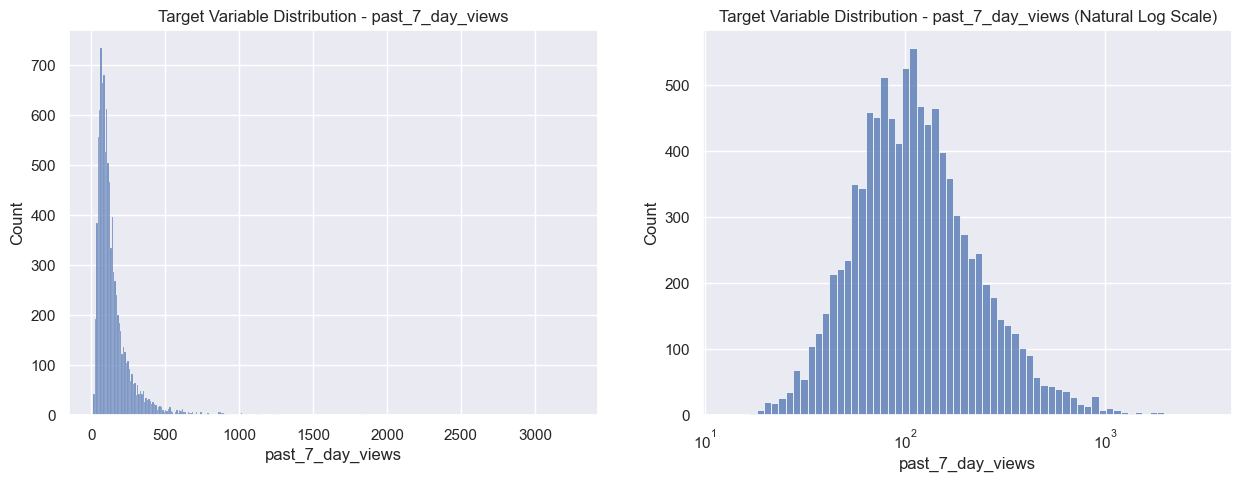

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data=df_eda, x='past_7_day_views', ax=ax[0]).set(title='Target Variable Distribution - past_7_day_views');
sns.histplot(data=df_eda, x='past_7_day_views', log_scale=True, ax=ax[1]).set(title='Target Variable Distribution - past_7_day_views (Natural Log Scale)');

### Numeric Variables - list_price_euro, age_in_years, length, width
Pairplot takes all numeric variables and plots their distribution individually (along the diagonal) and between other numeric variables as a scatter plot. Looking at the diagonal of the numeric variables, they are all positively skewed (right skewed) therefore, during model creation, it will be best to natural log normalize all numeric variables during model creation.

Inspecting the target variable against all other numeric variables, there does not seem to be any strong linear relationships. Best guess can be a weak positive linear relationship between past_7_day_views and age_in_years (0.12 correlation coeffecient). However, there does appear to be one between width and length. This is further verified with the heatmap which shows a strong linear positive relationship between length and width (0.87 correlation coeffecient). There is also a positive linear relationship between price_euro and width (0.52 correlation coeffecient) and price_euro and length (0.56 correlation coeffecient).

Positive relationship between length and width makes sense as you increase the length of a boat, the width should increase proportionally. Positive relationship between price and length and price and width also makes sense as you expect to recieve more money (point of view of a seller) for the longer or wider your boat is.

Column length and column width both have missing values. To understand how to impute the values, their distributions are explored. Both columns have outliers and imputing missing values using median is applicable.

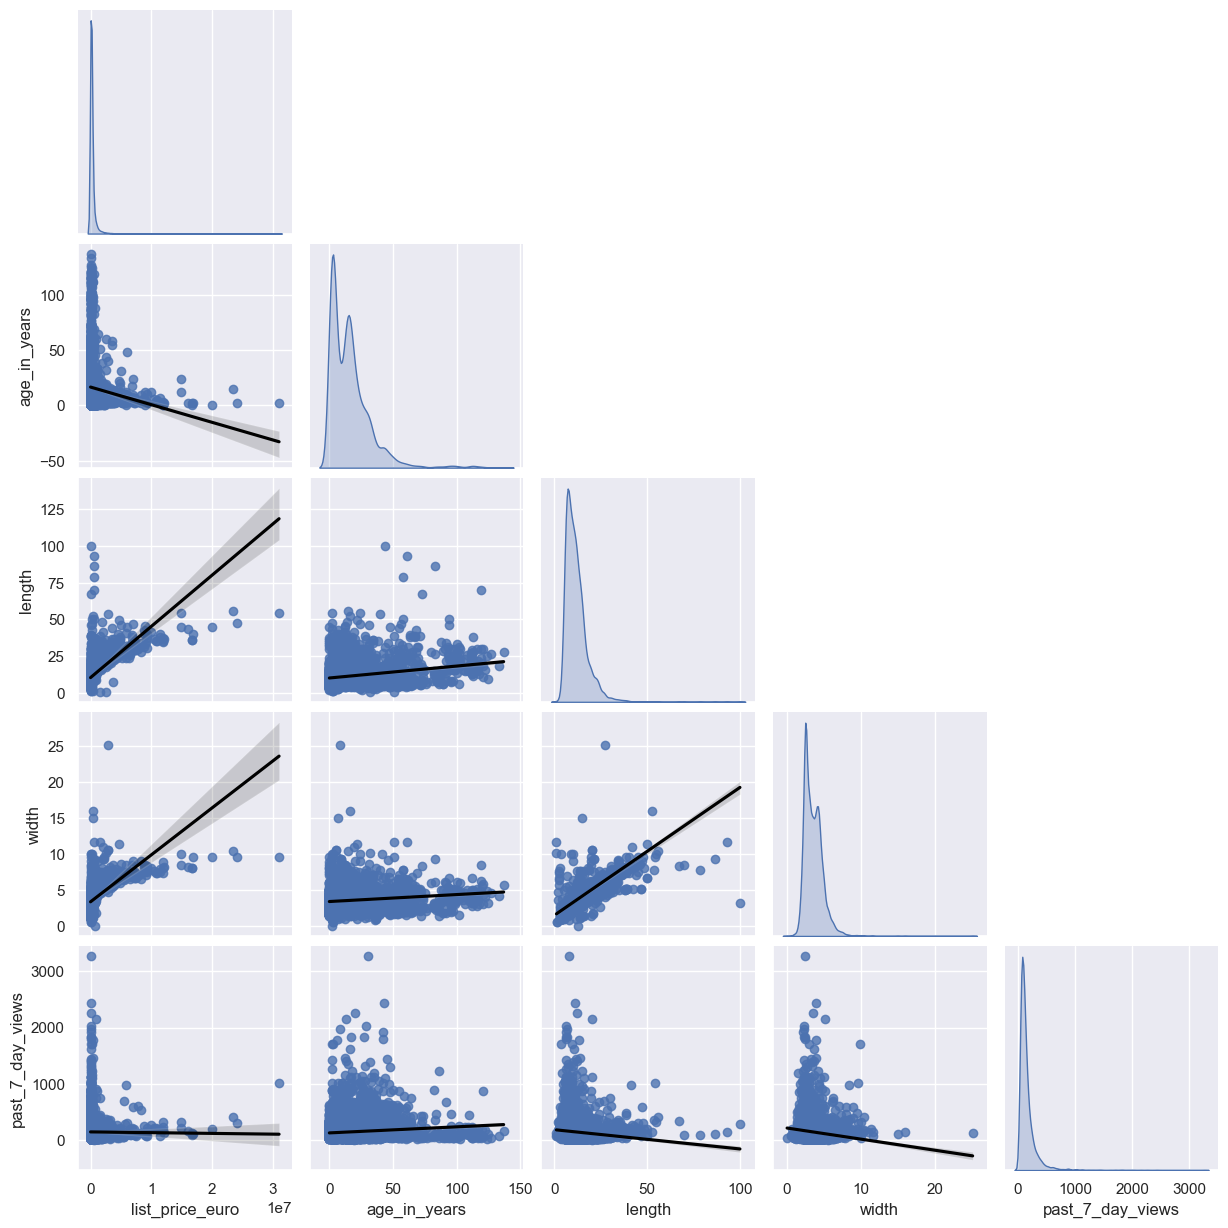

In [15]:
# generate pairplot for numeric variables
g = sns.pairplot(df_eda, corner=True, kind="reg", diag_kind="kde", plot_kws={'line_kws':{'color':'black'}})

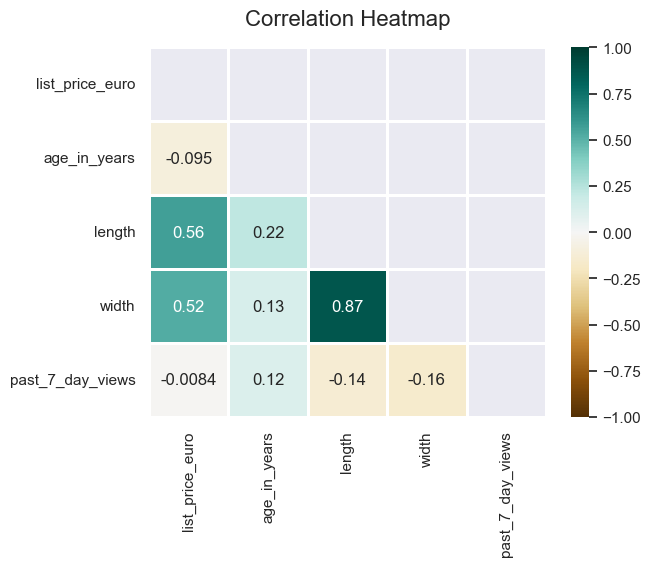

In [16]:
# create a mask to feed into heatmap
mask = np.triu(np.ones_like(df_eda.corr(), dtype=bool))
# generate a correlation heatmap
heatmap = sns.heatmap(df_eda.corr(), mask=mask, vmin=-1, vmax=1, annot=True, linewidths=1, cmap='BrBG').set_title('Correlation Heatmap', fontdict={'fontsize':16}, pad=16)

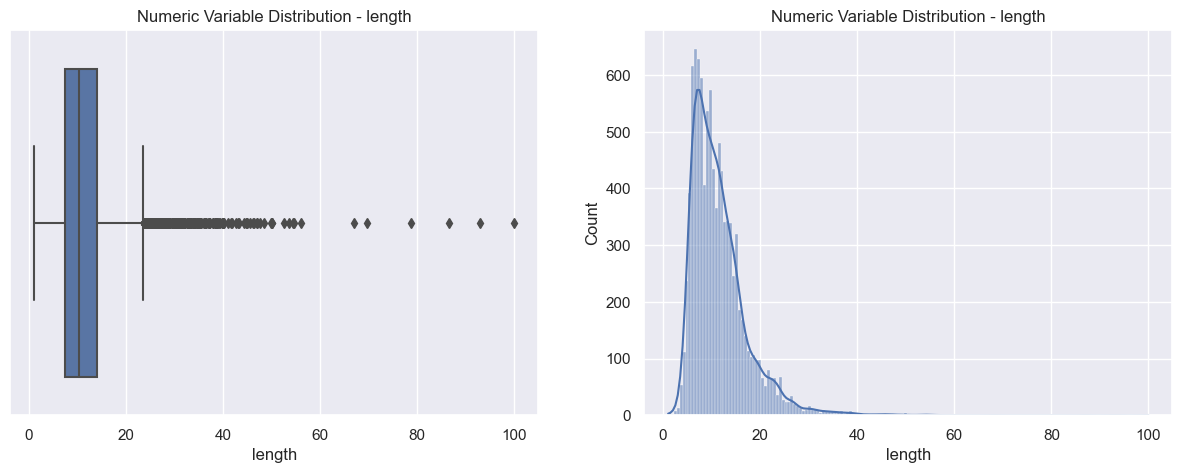

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(data=df_eda, x='length',ax=ax[0]).set(title='Numeric Variable Distribution - length')
sns.histplot(data=df_eda, x='length',ax=ax[1], kde=True).set(title='Numeric Variable Distribution - length');

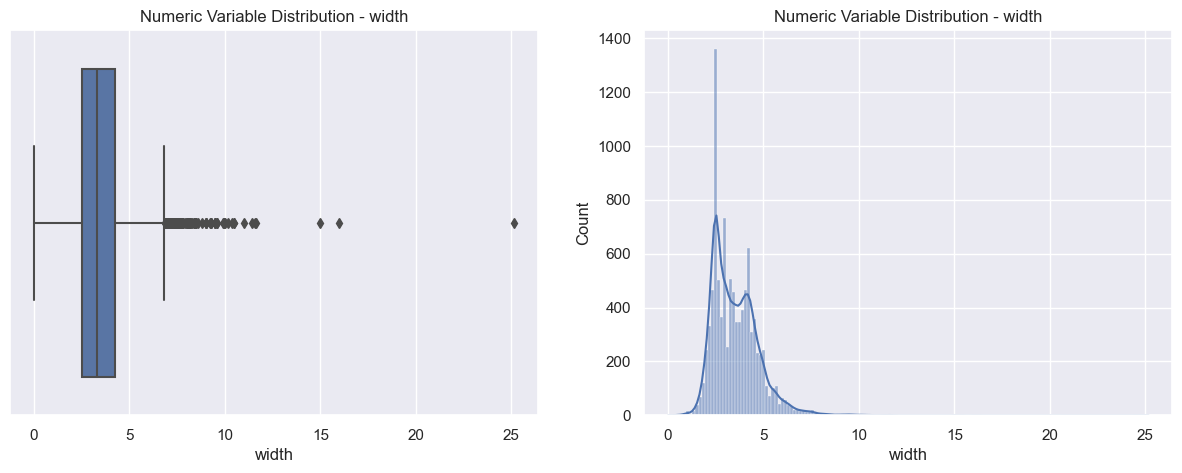

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(data=df_eda, x='width',ax=ax[0]).set(title='Numeric Variable Distribution - width');
sns.histplot(data=df_eda, x='width',ax=ax[1], kde=True).set(title='Numeric Variable Distribution - width');

### Categorical Variables - material, boat_type_1, condition
It is also important to see the counts and distributions of categorical variables. Given a boat's type, motor yacht are listed the most. Given a boat's condition, used boats are listed most. Given a boat's material, boats made of grp material are listed most.

condition and material both have missing values. When dealing with missing values in categorical data, imputing missing values using most frequent is applicable

[Text(0.5, 1.0, 'Count of Boats Listed Given Boat Type')]

[Text(0.5, 1.0, 'Count of Boats Listed Given Boat Condition')]

[Text(0.5, 1.0, 'Count of Boats Listed Given Boat Material')]

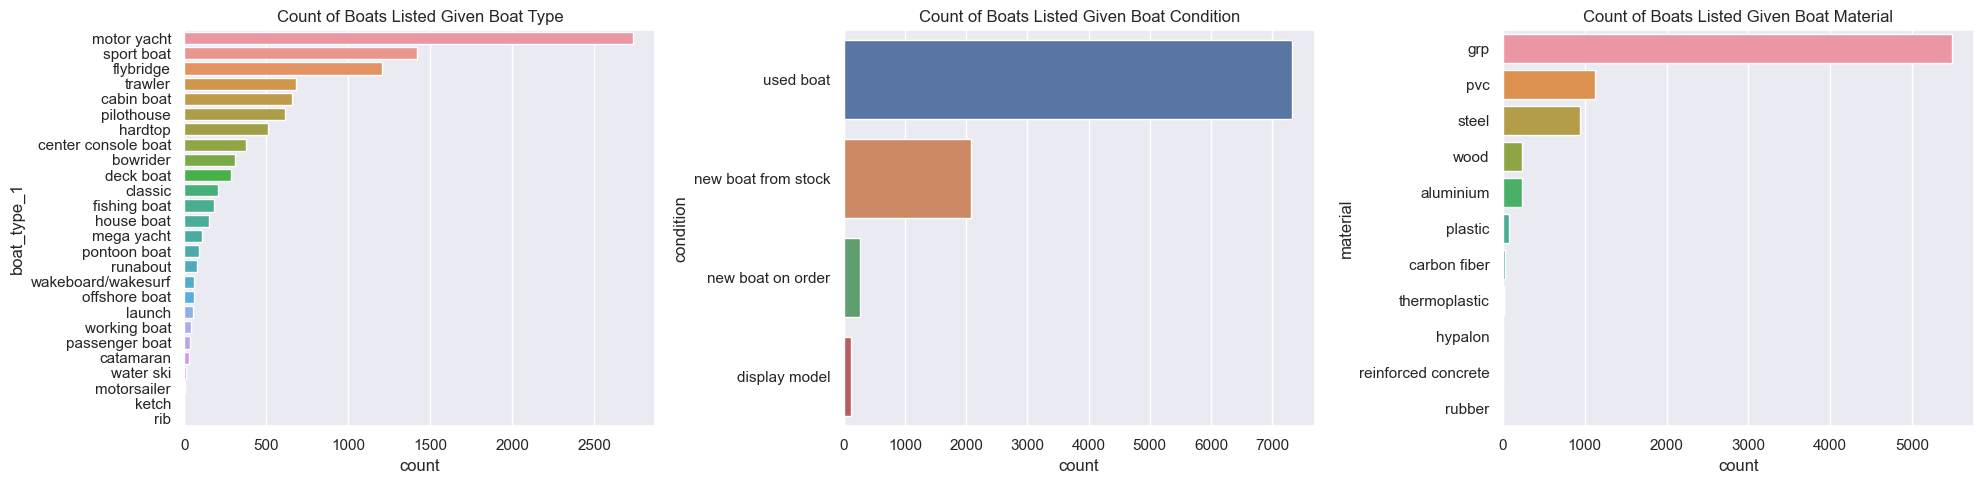

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
sns.countplot(data=df_eda, y="boat_type_1", order=df['boat_type_1'].value_counts().index, ax=ax[0]).set(title="Count of Boats Listed Given Boat Type");
sns.countplot(data=df_eda, y="condition", order=df_eda['condition'].value_counts().index, ax=ax[1]).set(title="Count of Boats Listed Given Boat Condition");
sns.countplot(data=df_eda, y="material", order=df_eda['material'].value_counts().index, ax=ax[2]).set(title="Count of Boats Listed Given Boat Material");
fig.tight_layout()

[Text(0.5, 1.0, 'Count of Boats Listed Given Boat Type')]

[Text(0.5, 1.0, 'Count of Boats Listed Given Boat Type')]

[Text(0.5, 1.0, 'Count of Boats Listed Given Boat Type')]

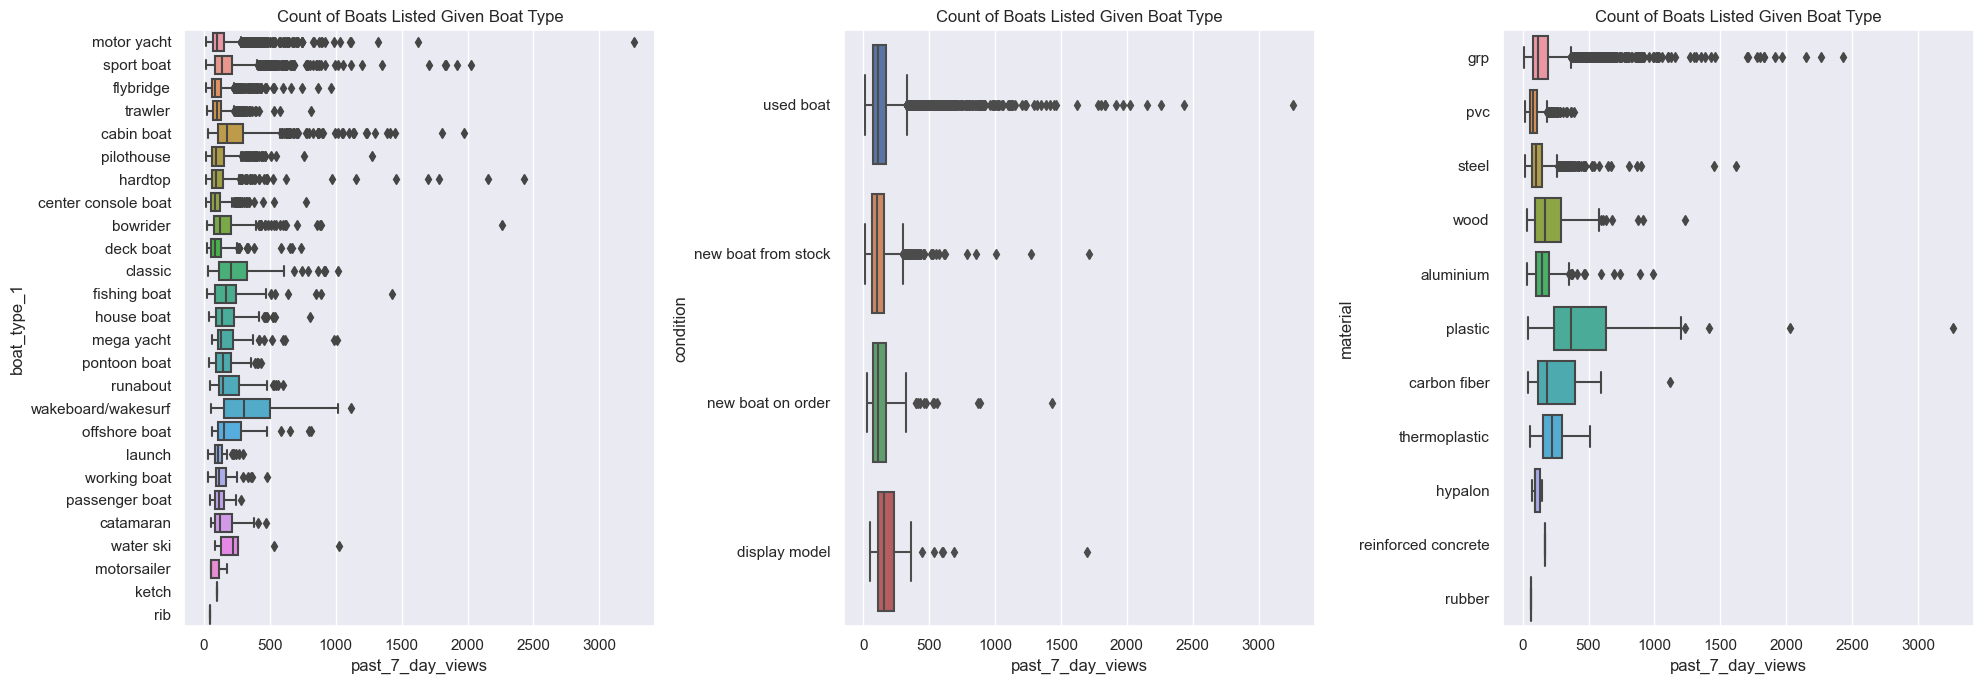

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(20,7))
sns.boxplot(data=df_eda, y="boat_type_1", x="past_7_day_views", order=df['boat_type_1'].value_counts().index, ax=ax[0]).set(title="Count of Boats Listed Given Boat Type");
sns.boxplot(data=df_eda, y="condition", x="past_7_day_views", order=df['condition'].value_counts().index, ax=ax[1]).set(title="Count of Boats Listed Given Boat Type");
# show distribution of material variable relative to past_7_day_views
sns.boxplot(data=df_eda, y="material", x="past_7_day_views", order=df['material'].value_counts().index, ax=ax[2]).set(title="Count of Boats Listed Given Boat Type");
fig.tight_layout()

## Model Development, including justification for your choice of models
This is a regression problem as the goal is to predict the number of views a boat listing could get based on its features. Baseline model will be a linear regression. After conducting the exploratory data analysis, there does not seem to be many strong linear relationships across features suggesting a comparative model good at capturing non-linear relationships: RandomForestRegressor.

To assess the models themselves, R-squared (coeffecient of determination) will be used. This metric is good as it explains how much predictive value the features have on the target variable. The higher this value, the better.
To help compare the models, RMSE (root mean squared error) will be used. This metric provides a scalar value with the same unit as the target variable, allowing for better comparison. The lower this value, the better.

Numeric variables missing values imputed using median and then normalized using PowerTransformer.
Categorical variables missing values imputed using most-frequent and transformed into numbers for model use with LabelEncoder.
Target variable is natural log transformed using numpy.log

In [21]:
categorical_features = ["boat_type_1", "condition", "material"]
numeric_features = ["list_price_euro", "age_in_years", "length", "width"]
target_feature = "past_7_day_views"

imputer_mode = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
df_eda[["condition"]] = imputer_mode.fit_transform(df_eda[["condition"]])
df_eda[["material"]] = imputer_mode.fit_transform(df_eda[["material"]])

label_encoder = LabelEncoder()
df_eda["boat_type_1"] = label_encoder.fit_transform(df_eda["boat_type_1"])
df_eda["condition"] = label_encoder.fit_transform(df_eda["condition"])
df_eda["material"] = label_encoder.fit_transform(df_eda["material"])

In [22]:
imputer_median = SimpleImputer(missing_values=np.nan, strategy="median")
df_eda[["length"]] = imputer_median.fit_transform(df_eda[["length"]])
df_eda[["width"]] = imputer_median.fit_transform(df_eda[["width"]])

In [23]:
scaler_pt = PowerTransformer()
df_eda[["list_price_euro", "age_in_years", "length", "width"]] = scaler_pt.fit_transform(df_eda[["list_price_euro", "age_in_years", "length", "width"]])

In [24]:
# take log of target value
df_eda["past_7_day_views"] = np.log(df_eda["past_7_day_views"])

In [25]:
# create feature variable dataframe
X = df_eda.drop(columns="past_7_day_views")

# create target variable series
y = df_eda["past_7_day_views"]

display(X, y)
display(X.shape, y.shape)

,list_price_euro,boat_type_1,condition,age_in_years,length,width,material
0,-3.059812,13,1,-0.645868,-2.306070,-1.754262,2
1,-3.028821,3,1,-1.207057,-2.306070,-2.483624,9
2,-2.930298,21,1,-1.953209,-2.516462,-2.649424,0
3,-3.031265,21,1,-1.207057,-3.058988,-3.666618,2
4,-3.056982,6,1,-0.983425,-2.617620,-2.565575,0
...,...,...,...,...,...,...,...
9883,-2.657131,21,3,1.216289,-1.147923,-0.967887,2
9884,-2.757821,21,1,-1.953209,-2.197899,-2.136468,2
9885,-2.761739,21,1,-1.207057,-2.058833,-1.922748,2
9886,-2.808843,18,1,-0.801001,-2.076523,-1.770740,2


0       5.420535
1       4.317488
2       4.820282
3       4.158883
4       4.060443
          ...   
9883    7.017506
9884    4.543295
9885    5.869297
9886    5.583496
9887    5.267858
Name: past_7_day_views, Length: 9888, dtype: float64

(9888, 7)

(9888,)

In [26]:
# instantiate LinearRegression()
linear_regression = LinearRegression()

# split data into training set (80%) and testing set (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# fit model to data
linear_regression.fit(X_train, y_train)

LinearRegression()

In [27]:
# instantiate RandomForestRegressor
rfr = RandomForestRegressor(random_state=42)

# split data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = [
    {'n_estimators': [100, 200, 300, 400, 450, 500], 
     'max_depth': [3, 4, 6, 8, 10, 12,], 
     'max_leaf_nodes': [15, 20, 25,30]}, 
]

rfr_cv = GridSearchCV(rfr, param_grid=param_grid, cv = 5, n_jobs = -1, verbose = 1)

# fit model to data
rfr_cv.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid=[{'max_depth': [3, 4, 6, 8, 10, 12],
                          'max_leaf_nodes': [15, 20, 25, 30],
                          'n_estimators': [100, 200, 300, 400, 450, 500]}],
             verbose=1)

## Model Evaluation, including explanation of what this means about your models
Baseline model generated R-squared of 0.1 and RMSE of 0.68. Comparative model generated R-squared of 0.24 and RMSE 0.63. The comparative model has a higher R-squared meaning model better captures the variation of the feature variables and lower RMSE meaning it has better predictive power than baseline model.

Therefore, the best model is the RandomForestRegressor with these hyperparameters: {'max_depth': 12, 'max_leaf_nodes': 30, 'n_estimators': 500}

In [ ]:
# generate predictions from the linear model on test set
linear_pred = linear_regression.predict(X_test)
f"R-squared: {linear_regression.score(X_test, y_test)}"
f"RMSE: {np.sqrt(mean_squared_error(y_test, linear_pred))}"

In [ ]:
_ = sns.barplot(x=X_train.columns, y=linear_regression.coef_).set(title="Linear Regression Feature Importance");
_ = plt.xticks(rotation="vertical")

In [ ]:
# Summarize results
best_score, best_params = rfr_cv.best_score_, rfr_cv.best_params_
print(f"Best: {best_score} using {best_params}")

# Extract the best model
best_model = rfr_cv.best_estimator_

In [ ]:
# generate predictions from the random forest regressor model on test set
rfr_pred = best_model.predict(X_test)
f"R-squared: {best_model.score(X_test, y_test)}"
f"RMSE: {np.sqrt(mean_squared_error(y_test, rfr_pred))}"

In [ ]:
_ = sns.barplot(x=X_train.columns, y=best_model.feature_importances_).set(title="Random Forest Regression Feature Importance");
_ = plt.xticks(rotation="vertical")

## Comparision to the business success criteria
Product manager would consider using the generated model if, on average, the predictions were only 50% off of the true number of views a listing would receive. The RandomForestRegressor has generated predictions which are 62% (0.6193124368048534) within the 50% range required by the product manager making this model meet requirements.

In [ ]:
df_kpi = pd.DataFrame({"log_actual_views":y_test, "log_predicted_views":rfr_pred})
df_kpi[["actual_views", "predicted_views"]] = df_kpi[["log_actual_views", "log_predicted_views"]].apply(np.exp, axis=0)
df_kpi["threshold_upper_views"] = df_kpi["actual_views"] * 1.5
df_kpi["threshold_lower_views"] = df_kpi["actual_views"] * 0.5
df_kpi["met_requirement"] = df_kpi.apply(lambda x: 1 if x["predicted_views"] >= x["threshold_lower_views"] and x["predicted_views"] <= x["threshold_upper_views"] else 0, axis=1)
df_kpi.met_requirement.mean()

## Final summary
Update the listing page on the website to force users to fill out all fields so none are left empty. This will lead to more accurate model training and better predictions (i.e. manufacturer should not be submitted as null) in the future. Add new columns for type to account for condition and fuel type seperately. In location, force users to input the country, state/province, city/region/suburb, postal code rather than whatever they want allowing for optimal data generation.

After conducting the exploratory data analysis, boat_type: motor yacht, condition: used boats, material: grp recieve the most views. Product manager should consider creating advertising that mention such words to create website traffic.

Looking at the RandomForestRegressor feature importance, list_price_euro is most important. This makes sense as the more expensive a listed boat is, the more individuals will be drawn to view it. But, this does not mean they will also purchase it as used boats recieved the most amount of views, being not the most expensive.

When it comes to boat_types ketch, rib and boat material: reinforced concrete and rubber, these listings can be removed as they did not generate any views.

As the RandomForestRegressor model meets the 50% requirement, the product manager can use the model.